## **Uygulama**

### Tüm uygulama kısımları birleştirilmiştir.

titanic.csv dosyası verileri kullanılmıştır.

In [169]:
##################### GEÇMİŞ TANIMLAMALAR ##############################

# Kütüphaneler
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler


# Pandas ayarları
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


# Veri setleri
def load_application_train():
    data = pd.read_csv('../01-outliers/application_train.csv')
    return data

def load():
    data = pd.read_csv('../01-outliers/titanic.csv')
    return data

# Fonksiyonlar
# outlier_thresholds fonksiyonu
# Alt ve üst sınırlarının belirlemek için kullanılacak
def outlier_thresholds(dataframe, col_name, q1 = 0.25, q3 = 0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

# Aykırı değer var mı yok mu kontrol eden fonksiyonu tanımlayalım. (return: True/False)(bool)
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

    # Bunu da kullanabiliriz.
    # if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].empty:
    #     return False
    # else:
    #     return True
        
# Efsane fonksiyon

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    -------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe.
        cat_th: int, optinal
                Kategorik değişkenlerinin sayısının üst sınırı.
        car_th: int, optional
                Kategorik fakat kardinal değişkenler için sınıf eşik değeri.
    
    Returns
    -------
        cat_cols: list
                Kategorik değişken listesi.
        num_cols: list
                Numerik değişken listesi.
        cat_but_car: list
                Kategorik kardinal değişken listesi.
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtype != 'O']
                   
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                     dataframe[col].dtype == 'O']
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtype != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print("******************")
    print(f"num_but_cat: {len(num_but_cat)}")
    return cat_cols, num_cols, cat_but_car

# grab_outliers fonksiyonu (eğer değişkene ait aykırı değer sayısı 10 dan fazla ise ilk 5 değerini göster, az ise hepsini göster)
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 0:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index
        

# Aykırı olmayan gözlemleri dönen fonksiyonları yazalım.
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_wıthout_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_wıthout_outliers


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe,variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df,end='\n')
    if na_name:
        return na_columns

# Label encoding için fonksiyon
def label_encoder(dataframe,binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

# Rare değişkenler için
def rare_analyser(dataframe, target, cat_cols):
    for col in  cat_cols:
        print(col,":",len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}),end="\n\n\n")
                    
# Rare encoding işlemini kriterlere göre uygulamak için fonksiyonumuzu yazalım.
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == "O"
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), "Rare", temp_df[var])
    
    return temp_df

# One hot encoding için fonksiyon tanımlayalım:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [170]:
df = load()
df.shape

(891, 12)

In [171]:
# Tüm column adlarını büyütmek için
df.columns = [col.upper() for col in df.columns]

In [172]:
#############################################################################
# 1. Feature Engineering (Değişken Mühendisliği)
#############################################################################

In [173]:
# Cabin var mi yok mu?
df["NEW_CABIN_BOOL"] = df["CABIN"].notnull().astype("int64")

In [174]:
# Name değişken uzunluğu
df["NEW_NAME_COUNT"] = df["NAME"].str.len()

In [175]:
# Name değişken kelime sayısı
df["NEW_NAME_WORD_COUNT"] = df["NAME"].apply(lambda x: len(str(x).split(" ")))

In [176]:
# Name değişken doktor mu?
df["NEW_NAME_DR"] = df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))

In [177]:
# Name değişken ünvanları
df["SPECIAL_TITLE"] = df.NAME.str.extract(' ([A-Za-z]+)\.', expand=False)

In [178]:
# Aile büyüklüğü
df["NEW_FAMILY_SIZE"] = df["SIBSP"] + df["PARCH"] + 1 

In [179]:
# Age pclass
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"] # Ayni satandart formda olamali

In [180]:
# is alone
df.loc[((df["SIBSP"] + df["PARCH"]) > 0), "NEW_IS_ALONE"] = 'NO'
df.loc[((df["SIBSP"] + df["PARCH"]) == 0), "NEW_IS_ALONE"] = 'YES'

In [181]:
# age level
df.loc[(df["AGE"]< 18), "NEW_AGE_CAT"] = 'young'
df.loc[(df["AGE"]>= 18 ) & (df["AGE"]< 56), "NEW_AGE_CAT"] = 'mature'
df.loc[(df["AGE"]>= 56), "NEW_AGE_CAT"] = 'senior'


In [182]:
# sex X age
df.loc[(df["SEX"] == "male") & (df["AGE"] <= 21), "NEW_SEX_CAT"] = "youngmale"
df.loc[(df["SEX"] == "male") & ((df["AGE"] >21) & (df["AGE"]) <= 50), "NEW_SEX_CAT"] = "maturemale"
df.loc[(df["SEX"] == "male") & (df["AGE"] > 50), "NEW_SEX_CAT"] = "seniormale"
df.loc[(df["SEX"] == "female") & (df["AGE"] <= 21), "NEW_SEX_CAT"] = "youngfemale"
df.loc[(df["SEX"] == "female") & ((df["AGE"] >21) & (df["AGE"]) <= 50), "NEW_SEX_CAT"] = "maturefemale"
df.loc[(df["SEX"] == "female") & (df["AGE"] > 50), "NEW_SEX_CAT"] = "seniorfemale"

In [183]:
df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,SPECIAL_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,0,23,4,0,Mr,2,66.000,NO,mature,maturemale
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,1,51,7,0,Mrs,2,38.000,NO,mature,maturefemale
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,0,22,3,0,Miss,1,78.000,YES,mature,maturefemale
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,1,44,7,0,Mrs,2,35.000,NO,mature,maturefemale
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0,24,4,0,Mr,1,105.000,YES,mature,maturemale


In [184]:
df.shape
#  Değişken sayısı 22 ye çıktı

(891, 22)

In [185]:
# Değişkenlerin türlerini bulalım.
cat_cols, num_cols, cat_but_car = grab_col_names(df) 

Observations: 891
Variables: 22
cat_cols: 14
num_cols: 5
cat_but_car: 3
******************
num_but_cat: 8


In [186]:
cat_cols

['SEX',
 'EMBARKED',
 'SPECIAL_TITLE',
 'NEW_IS_ALONE',
 'NEW_AGE_CAT',
 'NEW_SEX_CAT',
 'SURVIVED',
 'PCLASS',
 'SIBSP',
 'PARCH',
 'NEW_CABIN_BOOL',
 'NEW_NAME_WORD_COUNT',
 'NEW_NAME_DR',
 'NEW_FAMILY_SIZE']

In [187]:
num_cols

['PASSENGERID', 'AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

In [188]:
cat_but_car

['NAME', 'TICKET', 'CABIN']

In [189]:
# PASSENGERID ' yi istemiyorum.
num_cols.remove("PASSENGERID")
num_cols

['AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

In [190]:
#############################################################################
# 2. Outliers (Aykırı Değerler)
#############################################################################

In [191]:
for col in num_cols:
    print(col, check_outlier(df, col))
# Aykırı değerler var.

AGE True
FARE True
NEW_NAME_COUNT True
NEW_AGE_PCLASS True


In [192]:
# Aykırı değerleri baskılayalım.
for col in num_cols:
    replace_with_thresholds(df,col)

In [193]:
for col in num_cols:
    print(col, check_outlier(df, col))
# Aykırı değerler artık yok.

AGE False
FARE False
NEW_NAME_COUNT False
NEW_AGE_PCLASS False


In [194]:
#############################################################################
# 3. Missing Values (Eksik Değerler)
#############################################################################

In [195]:
missing_values_table(df)

                n_miss  ratio
CABIN              687 77.100
AGE                177 19.870
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
EMBARKED             2  0.220


In [196]:
# CABIN_BOOL değişkeni olduğu için CABIN değişkenini veri setinden kaldırıyoruz.
df.drop(["CABIN"], axis=1, inplace=True)

In [197]:
missing_values_table(df)

                n_miss  ratio
AGE                177 19.870
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
EMBARKED             2  0.220


In [198]:
# Aynı durum diğer değişkenler olan TICKET ve NAME değişkenleri için de geçerlidir.
remove_cols = ["TICKET", "NAME"]
df.drop(remove_cols, axis=1, inplace=True)

In [199]:
missing_values_table(df)

                n_miss  ratio
AGE                177 19.870
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
EMBARKED             2  0.220


In [200]:
df["AGE"] = df["AGE"].fillna(df.groupby('SPECIAL_TITLE')['AGE'].transform('median'))

In [201]:
missing_values_table(df)

                n_miss  ratio
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
EMBARKED             2  0.220


In [202]:
# NEW_AGE_PCLASS ve NEW_AGE_CAT değişkenlerini tekrar oluşturmamız gerekir.
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

# age level
df.loc[(df["AGE"]< 18), "NEW_AGE_CAT"] = 'young'
df.loc[(df["AGE"]>= 18 ) & (df["AGE"]< 56), "NEW_AGE_CAT"] = 'mature'
df.loc[(df["AGE"]>= 56), "NEW_AGE_CAT"] = 'senior'

# sex X age
df.loc[(df["SEX"] == "male") & (df["AGE"] <= 21), "NEW_SEX_CAT"] = "youngmale"
df.loc[(df["SEX"] == "male") & ((df["AGE"] >21) & (df["AGE"]) <= 50), "NEW_SEX_CAT"] = "maturemale"
df.loc[(df["SEX"] == "male") & (df["AGE"] > 50), "NEW_SEX_CAT"] = "seniormale"
df.loc[(df["SEX"] == "female") & (df["AGE"] <= 21), "NEW_SEX_CAT"] = "youngfemale"
df.loc[(df["SEX"] == "female") & ((df["AGE"] >21) & (df["AGE"]) <= 50), "NEW_SEX_CAT"] = "maturefemale"
df.loc[(df["SEX"] == "female") & (df["AGE"] > 50), "NEW_SEX_CAT"] = "seniorfemale"

In [203]:
missing_values_table(df)

          n_miss  ratio
EMBARKED       2  0.220


In [204]:
# Geriye kalan kategorik değişkenleri moduna göre dolduruyoruz.
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)

In [205]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [206]:
#############################################################################
# 4. Label Encodding
#############################################################################

In [207]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int,float]
                and df[col].nunique() == 2]

In [208]:
for col in binary_cols:
    df = label_encoder(df, col)

In [209]:
#############################################################################
# 5. Rare Encoding
#############################################################################

In [210]:
rare_analyser(df,"SURVIVED",cat_cols)

SEX : 2
   COUNT  RATIO  TARGET_MEAN
0    314  0.352        0.742
1    577  0.648        0.189


EMBARKED : 3
   COUNT  RATIO  TARGET_MEAN
C    168  0.189        0.554
Q     77  0.086        0.390
S    646  0.725        0.339


SPECIAL_TITLE : 17
          COUNT  RATIO  TARGET_MEAN
Capt          1  0.001        0.000
Col           2  0.002        0.500
Countess      1  0.001        1.000
Don           1  0.001        0.000
Dr            7  0.008        0.429
Jonkheer      1  0.001        0.000
Lady          1  0.001        1.000
Major         2  0.002        0.500
Master       40  0.045        0.575
Miss        182  0.204        0.698
Mlle          2  0.002        1.000
Mme           1  0.001        1.000
Mr          517  0.580        0.157
Mrs         125  0.140        0.792
Ms            1  0.001        1.000
Rev           6  0.007        0.000
Sir           1  0.001        1.000


NEW_IS_ALONE : 2
   COUNT  RATIO  TARGET_MEAN
0    354  0.397        0.506
1    537  0.603        0.304

In [211]:
df = rare_encoder(df,0.01)

In [212]:
df["SPECIAL_TITLE"].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: SPECIAL_TITLE, dtype: int64

In [213]:
#############################################################################
# 6. One Hot Encoding
#############################################################################

In [214]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

In [215]:
df = one_hot_encoder(df, ohe_cols)

In [216]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,PCLASS_2,PCLASS_3,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,SPECIAL_TITLE_Miss,SPECIAL_TITLE_Mr,SPECIAL_TITLE_Mrs,SPECIAL_TITLE_Rare,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale
0,1,0,1,22.000,7.250,0,23,0,66.000,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,2,1,0,38.000,65.634,1,45,0,38.000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,0,26.000,7.925,0,22,0,78.000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,0,35.000,53.100,1,44,0,35.000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,1,35.000,8.050,0,24,0,105.000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [217]:
df.shape

(891, 50)

In [218]:
# Rare ifadeleri tekrardan kontrol etmemiz gerekir.
# Önce kategorik sayısal olanları belirleyeilim.

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 50
cat_cols: 45
num_cols: 5
cat_but_car: 0
******************
num_but_cat: 45


In [219]:
num_cols.remove("PASSENGERID")

In [220]:
rare_analyser(df,"SURVIVED",cat_cols)
# Yeni problem: Oluşturulan yeni değişkenler bilgi taşıyor mu? (Oranları dengeli mi?)
# DEĞİL

SURVIVED : 2
   COUNT  RATIO  TARGET_MEAN
0    549  0.616        0.000
1    342  0.384        1.000


SEX : 2
   COUNT  RATIO  TARGET_MEAN
0    314  0.352        0.742
1    577  0.648        0.189


NEW_CABIN_BOOL : 2
   COUNT  RATIO  TARGET_MEAN
0    687  0.771        0.300
1    204  0.229        0.667


NEW_NAME_DR : 2
   COUNT  RATIO  TARGET_MEAN
0    881  0.989        0.383
1     10  0.011        0.500


NEW_IS_ALONE : 2
   COUNT  RATIO  TARGET_MEAN
0    354  0.397        0.506
1    537  0.603        0.304


PCLASS_2 : 2
   COUNT  RATIO  TARGET_MEAN
0    707  0.793        0.361
1    184  0.207        0.473


PCLASS_3 : 2
   COUNT  RATIO  TARGET_MEAN
0    400  0.449        0.557
1    491  0.551        0.242


SIBSP_1 : 2
   COUNT  RATIO  TARGET_MEAN
0    682  0.765        0.337
1    209  0.235        0.536


SIBSP_2 : 2
   COUNT  RATIO  TARGET_MEAN
0    863  0.969        0.381
1     28  0.031        0.464


SIBSP_3 : 2
   COUNT  RATIO  TARGET_MEAN
0    875  0.982        0.386
1     

In [221]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and (df[col].value_counts() / len(df) < 0.01).any(axis=None)]

In [222]:
useless_cols

['SIBSP_5',
 'SIBSP_8',
 'PARCH_3',
 'PARCH_4',
 'PARCH_5',
 'PARCH_6',
 'NEW_NAME_WORD_COUNT_9',
 'NEW_NAME_WORD_COUNT_14',
 'NEW_FAMILY_SIZE_8',
 'NEW_FAMILY_SIZE_11']

In [223]:
# Silmek için:
# df.drop(useless_cols, axis=1, inplace=True)

In [224]:
#############################################################################
# 7. Standarlaştırma
#############################################################################
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df[num_cols].head()

,AGE,FARE,NEW_NAME_COUNT,NEW_AGE_PCLASS
0,-0.561,-0.821,-0.437,0.066
1,0.663,2.032,2.248,-0.790
2,-0.255,-0.788,-0.559,0.434
3,0.434,1.419,2.126,-0.882
4,0.434,-0.781,-0.315,1.260


In [231]:
#############################################################################
# 8. Model
#############################################################################

y = df["SURVIVED"]
X = df.drop(["PASSENGERID","SURVIVED"], axis=1)

In [232]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=17)

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=46).fit(X_train,y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred,y_test)

0.8059701492537313

In [227]:
# # Hiçbir işlem yapmasaydık ne olacaktı?
# #############################################################################
# dff = load()

# # Eksik değerleri kaldıralım.
# dff.dropna(inplace=True) # Eksik değer olursa RandomForest bu datasetinde çalışmmaz.

# # SEX ve EMBARKED değişkenine encoding yapalım.
# dff = pd.get_dummies(dff, columns=["Sex","Embarked"],drop_first=True)
# y = dff["Survived"]
# X = dff.drop(["PassengerId","Survived","Name","Ticket","Cabin"],axis=1)
# X_train, X_test , y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=17)
# rf_model2 = RandomForestClassifier(random_state=46).fit(X_train,y_train)
# y_pred = rf_model2.predict(X_test)
# accuracy_score(y_pred,y_test)

0.7090909090909091

In [228]:
# Yeni ürettiğimiz değişkenler ne alemde?

def plot_importance(model,features,num=len(X),save=False):
    feature_imp = pd.DataFrame({"Value":model.feature_importances_,"Feature":features.columns})
    plt.figure(figsize=(10,10))
    sns.set(font_scale=1)
    sns.barplot(x="Value",y="Feature",data=feature_imp.sort_values(by="Value",ascending=False)[0:num])
    
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("feature_importance.png")

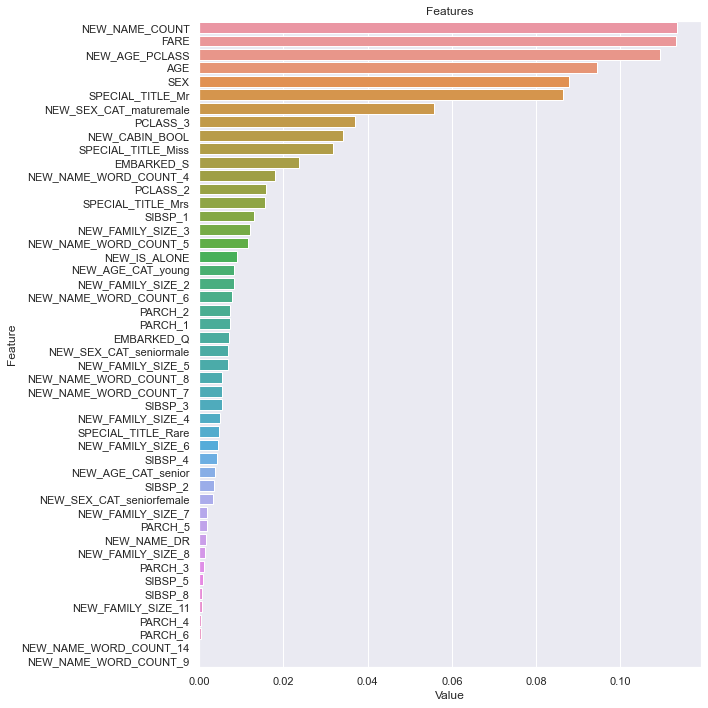

In [234]:
# Değişkenlerin anlamlılığın fazladan aza
plot_importance(rf_model,X_train)